In [92]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Libraries

In [94]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from textblob import TextBlob
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import pairwise_distances

# # importing pre-trained universal sentence encoder
# embed_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

# dataframe display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# plotting style
plt.style.use('ggplot')
sns.set_style('darkgrid')

In [95]:
# checking for GPU
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# User defined functions

In [96]:
# defining function to tokenize the text
def tokenize_text(text, keep_punctuation=""):
    '''
    This function takes text string as input and:
        1. Extracts the text by excluding the HTML tags
        2. Converts the casing of all characters to lower casing
        3. Removes puncuation, special characters, digits, etc, if any values are passed to keep_punctuation param, ignores them
        4. If any specific punctuations are retained, treat them as seperate word
        5. Split the text string into (list of) words
        6. Remove stopwords
    '''
    # compiling the string match for HTML tag
    tag = re.compile("<.*?>")
    # excluding the HTML tags and retaining only the text
    text = re.sub(tag, " ", text)
    
    # converting the casing to lower
    text_lower = text.lower()
    
    # cleaning text
    text_lower_cleaned = re.sub("[^a-z" + keep_punctuation + "]", " ", text_lower)
    
    # converting the retained punctuations as seperate words
    if keep_punctuation != "":
        # adding a single space infront of every punctuation to treat it as a seperate word
        for l in keep_punctuation:
            text_lower_cleaned = re.sub(l, " "+l, text_lower_cleaned)
    
    # splitting text string into words
    text_lower_cleaned_words = text_lower_cleaned.split()
    
    # stopwords, converting into set for faster comparision
    stops = set(stopwords.words("english"))
    
    # removing stopwords
    tokens = [word for word in text_lower_cleaned_words if word not in stops]
    
    # returning the list of tokens
    return tokens

# Reading data

In [97]:
# reading data from csv and creating a dataframe
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

# dataframe dimensions
print(f"This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")

This dataframe has 568454 rows and 10 columns.


In [98]:
# columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [99]:
# sample rows
df.sample(5)

Id   ProductId          UserId          ProfileName  \
11442    11443  B0001U4VK4  A35X82IY1F5CHZ                 Yrod   
60537    60538  B003QNJYXM  A1MUHQ0JMPOF0Q           Johanna L.   
115929  115930  B000F0FZAU  A2MUGFV2TDQ47K  Lynrie "Oh HELL no"   
336673  336674  B005GX8MMO   ACUGYK1I1N3N0        Amazing Grace   
548528  548529  B003LPZSN0  A1IYJLO8UXPW36    Cathleen M. Jones   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
11442                      0                       0      5  1345766400   
60537                      0                       0      4  1346371200   
115929                     0                       0      5  1323907200   
336673                     1                       2      5  1281744000   
548528                     0                       0      4  1318723200   

                             Summary  \
11442                         Happy!   
60537      Energy without the crash!   
115929  It'll Cure Whatever Ails You   
336673       GREAT TASTING COFFEE!!!   
548528             Works pretty well   

                                                     Text  
11442   This is something I was looking for the office...  
60537   After a long week of projects at work I was ex...  
115929  The other reviewer's comments influenced my pu...  
336673  I bought this coffee for my Bialetti Cappuccin...  
548528  There is a lot of tracked litter, but that jus...

# Missing values

In [100]:
# missing values summary
pd.DataFrame(zip(df.columns,
                 df.isna().any(),
                 df.isna().sum()\
                     / df.shape[0]\
                     * 100),
            columns=['Column', 'Has Missing Values?', '% Missing Values'])\
    .sort_values('% Missing Values', ascending=False)

Column  Has Missing Values?  % Missing Values
8                 Summary                 True          0.004750
3             ProfileName                 True          0.002815
0                      Id                False          0.000000
1               ProductId                False          0.000000
2                  UserId                False          0.000000
4    HelpfulnessNumerator                False          0.000000
5  HelpfulnessDenominator                False          0.000000
6                   Score                False          0.000000
7                    Time                False          0.000000
9                    Text                False          0.000000

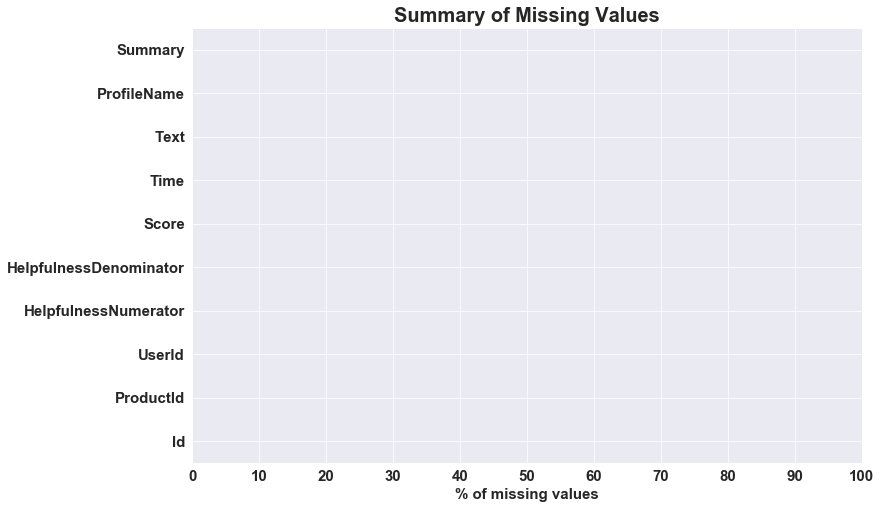

In [101]:
# visual summary of % of missing values in each column
(df.isna()\
         .sum()\
         / df.shape[0]\
         * 100)\
    .sort_values()\
    .plot(kind='barh', figsize=(12,8))
plt.xticks(np.arange(0,110,10), fontsize=15, fontweight='bold')
plt.xlabel("% of missing values", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Summary of Missing Values", fontsize=20, fontweight='bold')
plt.show()

**Observations:**

* `Summary` and `ProfileName` have missing values. Also, these columns have less than 1% missing values.
* We can ignore the missing values, it wouldn't affect our analysis and predictions. But for computation purposes, let's replace the NULLs with empty stings.

In [102]:
# replacing NULLs with empty string
df.fillna("", inplace=True)

# Sentiment analysis

Let's build a model to extract the sentiment from the user review text. We will be using *Universal Sentence Encoder*, a pre-trained model, to transform the review text into fixed-length 512 dimension sentence embeddings.

### Preparing data

Let's preprocess the review text and prepare the data for training a FNN model to predict the sentiment.

1. Creating a binary label from the score values.
2. Split into train and test sets.
3. Treat class imbalance by down-sampling the majority class.
4. Transform the review text into embedded vectors using *Universal Sentence Encoder*.

In [103]:
# # dataframe for sentiment analysis
# df_text = pd.DataFrame(df['Summary'] + " " + df['Text'], columns=['ReviewText'])

# # creating the label and appending to the dataframe
# df_text['Label'] = df['Score'].apply(lambda x: "Positive" if x >= 4 else "Negative")

In [104]:
# # compiling the string match for HTML tag
# tag = re.compile("<.*?>")

# # removing the HTML tags and retaining only the text
# df_text['CleanedText'] = df_text['ReviewText'].apply(lambda x: re.sub(tag, " ", x))

In [105]:
# # class distribution
# plt.subplots(1,2, figsize=(15,6))

# # countplot to visualize the no. of observations under each class
# plt.subplot(1,2,1)
# ax = sns.countplot(df_text['Label'])
# #plt.xticks([0,1], labels=['Negative', 'Positive'])
# plt.title('No. of obervations in each class', fontsize=15)
# for i in ax.patches:
#     # get_x pulls left or right; get_height pushes up or down
#     ax.text(i.get_x()+0.3, i.get_height(), str(round(i.get_height(), 2)), fontsize=15, color='black')

# # pie chart to visualize the percentage distribution of each class
# plt.subplot(1,2,2)
# plt.pie(df_text['Label'].value_counts(), labels=['Positive', 'Negative'], autopct='%.2f', explode=[0, 0.05])
# plt.title('Percentage distribution of each class', fontsize=15)

# plt.show()

In [106]:
# # comparing the frequently used words in each class
# plt.subplots(1,2, figsize=(18,8))

# # word cloud - positive sentiment class
# plt.subplot(1,2,1)
# corpus = " ".join(df_text.loc[(df_text['Label'] == "Positive"), "CleanedText"].to_numpy().tolist())
# wordcloud = WordCloud(width=800, height=720, background_color="black").generate(corpus)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title("Frequently used words - Positive Reviews", fontsize=18, fontweight='bold')

# # word cloud - negative sentiment class
# plt.subplot(1,2,2)
# corpus = " ".join(df_text.loc[(df_text['Label'] == "Negative"), "CleanedText"].to_numpy().tolist())
# wordcloud = WordCloud(width=800, height=720, background_color="black").generate(corpus)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title("Frequently used words - Negative Reviews", fontsize=18, fontweight='bold')

# plt.show()

**Observations:**

* We can see that *love* is a common word in positive reviews.
* Most of the user reviews are about product taste and flavor (makes sense since these are food products) and some others are about price, smell, texture.
* We can see that words like *bad*, *disappointment* appear in the negative reviews.
* There is not much difference in terms of tokens, since both the positive and negative reviews talk about similar aspects of a product.

In [107]:
# # splitting into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(df_text['CleanedText'],
#                                                     df_text['Label'],
#                                                     test_size=0.2,
#                                                     stratify=df_text['Label'],
#                                                     random_state=42)

In [108]:
# # positive reviews
# positive_reviews = X_train[y_train == "Positive"].sample(n=sum(y_train == "Negative"), replace=False, random_state=42)

# # negative reviews
# negative_reviews = X_train[y_train == "Negative"]

# # creating a down-sampled train set
# df_pos = pd.DataFrame(positive_reviews, columns=['CleanedText'])
# df_pos['Label'] = "Positive"
# df_neg = pd.DataFrame(negative_reviews, columns=['CleanedText'])
# df_neg['Label'] = "Negative"
# df_train = df_pos.append(df_neg).reset_index(drop=True)
# df_train = df_train.sample(frac=1, random_state=33)

# # X_train and y_train
# X_train = df_train['CleanedText']
# y_train = df_train['Label']

In [109]:
# # encoding target variable
# y_train = pd.get_dummies(y_train)
# y_test = pd.get_dummies(y_test)

In [110]:
# # creating embeddings using universal sequential encoder
# X_train = np.array([tf.reshape(embed_use([text]), [-1]).numpy() for text in tqdm(X_train)])

In [111]:
# # creating embeddings using universal sequential encoder
# X_test = np.array([tf.reshape(embed_use([text]), [-1]).numpy() for text in tqdm(X_test)])

### Model to predict sentiment

Let's build a Feed-forward Neural Network model and train it on the sentence embeddings to predict the sentiment.

In [112]:
# # constructing a feed-forward neural network
# model_predict_sentiment = keras.Sequential()
# model_predict_sentiment.add(keras.layers.Dense(units=256, input_shape=(512, ), activation='relu'))
# model_predict_sentiment.add(keras.layers.Dropout(rate=0.2))
# model_predict_sentiment.add(keras.layers.Dense(units=128, activation='relu'))
# model_predict_sentiment.add(keras.layers.Dropout(rate=0.2))
# model_predict_sentiment.add(keras.layers.Dense(2, activation='softmax'))
# model_predict_sentiment.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
# model_predict_sentiment.summary()

In [113]:
# # fitting the model with train data
# train_history = model_predict_sentiment.fit(X_train, y_train,
#                                               epochs=15,
#                                               batch_size=16,
#                                               validation_split=0.1,
#                                               verbose=1,
#                                               shuffle=True)

In [114]:
# training loss and accuracy

In [115]:
# evaluating on test data

### Extracting sentiment for all the reviews

In [116]:
# # creating embeddings for review text
# input_embeddings = np.array([tf.reshape(embed_use([text]), [-1]).numpy() for text in tqdm(df_text['CleanedText'])])

In [117]:
# predicting the sentiment using the model

# Feature engineering

### HelpfulnessRatio

Let's calculate the `HelpfulnessRatio` value by diving the `HelpfulnessNumerator` with `HelpfulnessDenominator`.

$$HelpfulnessRatio = \frac{HelpfulnessNumerator}{HelpfulnessDenominator}$$

In [118]:
# HelpfulnessRatio
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']

# replacing the NaN values with 0
df['HelpfulnessRatio'].fillna(0, inplace=True)

### SummaryLength

Let's calculate the length (no. of characters) in the `Summary` text.

In [119]:
# SummaryLength
df['SummaryLength'] = df['Summary'].str.len()

### SummaryTokens

Let's tokenize the `Summary` text.

In [120]:
# SummaryTokens
df['SummaryTokens'] = df['Summary'].apply(lambda x: tokenize_text(x, keep_punctuation="!"))

### TextLength

Let's calculate the length (no. of characters) in the actual review `Text`.

In [121]:
# TextLength
df['TextLength'] = df['Text'].str.len()

### TextTokens

Let's tokenize the `Text` text.

In [122]:
# TextTokens
df['TextTokens'] = df['Text'].apply(lambda x: tokenize_text(x, keep_punctuation="!"))

### ReviewText

Concatnating `Summary` and `Text` columns to get the complete `ReviewText`.

In [123]:
# ReviewText
df['ReviewText'] = df['Summary'] + " " + df['Text']

### ReviewLength

Let's calculate the length (no. of characters) in the complete `Review` text.

In [124]:
# ReviewLength
df['ReviewLength'] = df['ReviewText'].str.len()

### ReviewTokens

Let's tokenize the `Review` text.

In [125]:
# ReviewTokens
df['ReviewTokens'] = df['SummaryTokens'] + df['TextTokens']

### NoOfTokens

Calculate the number of tokens (words excluding stopswords) in each review.

In [126]:
# NoOfTokens
df['NoOfTokens'] = df['ReviewTokens'].apply(lambda x: len(x))

### NoOfPunctuations

Let's count the number of punctuations (!) used in the review text.

In [127]:
# NoOfPunctuations
df['NoOfPunctuations'] = df['ReviewTokens'].apply(lambda x: x.count("!"))

### SentimentScore

Let's extract sentiment score from the user review text.

In [128]:
# dataframe for sentiment analysis
df_text = pd.DataFrame(df['Summary'] + " " + df['Text'], columns=['ReviewText'])

# compiling the string match for HTML tag
tag = re.compile("<.*?>")

# removing the HTML tags and retaining only the text
df_text['CleanedText'] = df_text['ReviewText'].apply(lambda x: re.sub(tag, " ", x))

# extracting polarity from the review text
df_text['Polarity'] = df_text['CleanedText'].apply(lambda x: TextBlob(x).sentiment.polarity)

# normalizing the polarity values to get sentiment score
df['SentimentScore'] = df_text['Polarity'].apply(lambda x: (x + 1) / 2)

# Exploratory data analysis

### Subsetting the data

In [129]:
# keeping on the required columns for analysis
# dropping Id and Time
df_eda = df.drop(columns=['Id','Time'])

# new dataframe dimensions
print(f"This dataframe has {df_eda.shape[0]} rows and {df_eda.shape[1]} columns.")

This dataframe has 568454 rows and 19 columns.


In [130]:
# rearranging the columns
df_eda = df_eda[['ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','HelpfulnessRatio',
                 'Score','Summary','SummaryLength','SummaryTokens',
                 'Text','TextLength','TextTokens',
                 'ReviewText','ReviewLength','ReviewTokens',
                 'NoOfTokens','NoOfPunctuations']]

# sample rows
df_eda.sample(5)

ProductId          UserId                ProfileName  \
352617  B004HOQDK6  A10GVY892KV8P8            Mahali Benjamin   
141393  B0047RQ9M0  A33WJZ4EWB0GGN                  princess1   
5533    B002Y7520K  A2NFN9JRKFFCT6                 praymor4me   
441632  B0030N5JIM  A35B8ZMAE909F5    L. Malessa "Valley Mom"   
351595  B000UXVIYO  A28JE1K2R6STBT  Elena M. "online shopper"   

        HelpfulnessNumerator  HelpfulnessDenominator  HelpfulnessRatio  Score  \
352617                     0                       4              0.00      1   
141393                     0                       0              0.00      5   
5533                       0                       0              0.00      5   
441632                     0                       0              0.00      5   
351595                     3                       4              0.75      5   

                                         Summary  SummaryLength  \
352617  100% Natural or Chocolate covered for me             40   
141393                              Great coffee             12   
5533                           blueberry extract             17   
441632                      It really does work!             20   
351595                                  Love it.              8   

                        SummaryTokens  \
352617  [natural, chocolate, covered]   
141393                [great, coffee]   
5533             [blueberry, extract]   
441632              [really, work, !]   
351595                         [love]   

                                                     Text  TextLength  \
352617  I bought Blue Diamond Natural Chocolate almond...         352   
141393  This is my favorite coffee for my Keurig coffe...         177   
5533    arrived on time,smells like a good addition to...         122   
441632  I was paying $70 for feline ZD. The last draw ...         569   
351595  We've eating jasmine rice for quite some time....         315   

                                               TextTokens  \
352617  [bought, blue, diamond, natural, chocolate, al...   
141393  [favorite, coffee, keurig, coffeemaker, conven...   
5533    [arrived, time, smells, like, good, addition, ...   
441632  [paying, feline, zd, last, draw, vet, told, wo...   
351595  [eating, jasmine, rice, quite, time, lots, fla...   

                                               ReviewText  ReviewLength  \
352617  100% Natural or Chocolate covered for me I bou...           393   
141393  Great coffee This is my favorite coffee for my...           190   
5533    blueberry extract arrived on time,smells like ...           140   
441632  It really does work! I was paying $70 for feli...           590   
351595  Love it. We've eating jasmine rice for quite s...           324   

                                             ReviewTokens  NoOfTokens  \
352617  [natural, chocolate, covered, bought, blue, di...          36   
141393  [great, coffee, favorite, coffee, keurig, coff...          17   
5533    [blueberry, extract, arrived, time, smells, li...          16   
441632  [really, work, !, paying, feline, zd, last, dr...          57   
351595  [love, eating, jasmine, rice, quite, time, lot...          33   

        NoOfPunctuations  
352617                 0  
141393                 0  
5533                   0  
441632                 2  
351595                 0

### Basic summary statistics (or) Univariate analysis

In [131]:
# no. of unique products and users
df[['ProductId','UserId']].describe().T

count  unique             top freq
ProductId  568454   74258      B007JFMH8M  913
UserId     568454  256059  A3OXHLG6DIBRW8  448

**Observations:**

* So, we have 74,258 unique products, sweet!
* And, there are 2,56,059 unique users.

In [132]:
# summary of review scores
df[['HelpfulnessNumerator','HelpfulnessDenominator','HelpfulnessRatio','Score']].describe().T

count      mean       std  min  25%  50%  75%  \
HelpfulnessNumerator    568454.0  1.743817  7.636513  0.0  0.0  0.0  2.0   
HelpfulnessDenominator  568454.0  2.228810  8.289740  0.0  0.0  1.0  2.0   
HelpfulnessRatio        568454.0  0.407862  0.462068  0.0  0.0  0.0  1.0   
Score                   568454.0  4.183199  1.310436  1.0  4.0  5.0  5.0   

                          max  
HelpfulnessNumerator    866.0  
HelpfulnessDenominator  923.0  
HelpfulnessRatio          3.0  
Score                     5.0

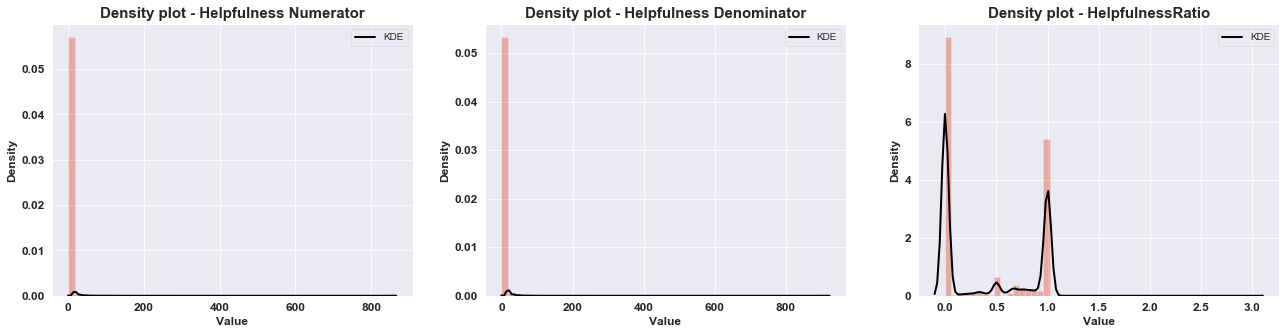

In [133]:
# plotting the values
plt.subplots(1,3, figsize=(22,5))

# HelpfulnessNumerator
plt.subplot(1,3,1)
sns.distplot(df['HelpfulnessNumerator'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Helpfulness Numerator", fontsize=15, fontweight='bold')

# HelpfulnessDenominator
plt.subplot(1,3,2)
sns.distplot(df['HelpfulnessDenominator'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Helpfulness Denominator", fontsize=15, fontweight='bold')

# Score
plt.subplot(1,3,3)
sns.distplot(df['HelpfulnessRatio'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - HelpfulnessRatio", fontsize=15, fontweight='bold')

plt.show()

**Observations:**

* Majority of `Helpfulness` scores are zero. And they are heavily right skewed.
* Majority of `HelpfulnessRatio` values are zero, since we have seen that majority of the `Helpfulness` score were zero.
* Excluding these values, among non-zero `Helpfulness` scores, majority of the `HelpfulnessRatio` values are 1. Meaning, most of the reviews are helpful for the users, i.e. quality reviews.

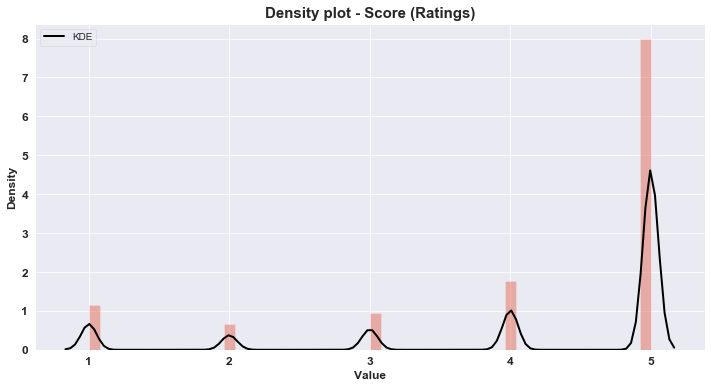

In [134]:
# Score (ratings)
plt.figure(figsize=(12,6))
sns.distplot(df['Score'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Score (Ratings)", fontsize=15, fontweight='bold')
plt.show()

**Observations:**

* Majority of `Score` (product rating) values are 5 (good to know products on Amazon are good).
* We can also notice that distribution of product ratings is similar of inverted bell-curve, meaning, there are more number of 1 rating scores than 2 rating scores.

In [135]:
# summary of summary text and review text length
df_eda[['SummaryLength','TextLength','ReviewLength','NoOfTokens','NoOfPunctuations']].describe().T

count        mean         std   min    25%    50%    75%  \
SummaryLength     568454.0   23.445744   14.028662   0.0   13.0   20.0   30.0   
TextLength        568454.0  436.222083  445.339741  12.0  179.0  302.0  527.0   
ReviewLength      568454.0  460.667827  449.843589  23.0  200.0  325.0  554.0   
NoOfTokens        568454.0   43.499764   40.817403   0.0   20.0   31.0   52.0   
NoOfPunctuations  568454.0    1.094713    1.997586   0.0    0.0    0.0    2.0   

                      max  
SummaryLength       128.0  
TextLength        21409.0  
ReviewLength      21535.0  
NoOfTokens         1974.0  
NoOfPunctuations     91.0

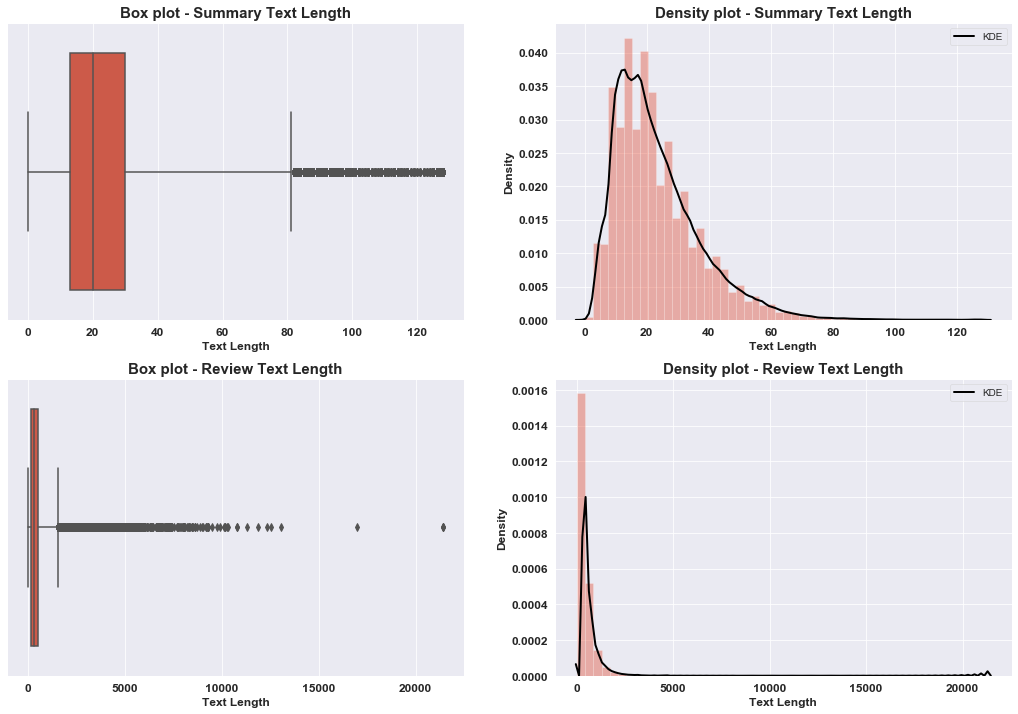

In [136]:
# distribution of summary text and review text length values
plt.subplots(2,2, figsize=(18,12))

# summary text
plt.subplot(2,2,1)
sns.boxplot(df_eda['SummaryLength'], whis=3)
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Text Length", fontsize=12, fontweight='bold')
plt.title("Box plot - Summary Text Length", fontsize=15, fontweight='bold')

plt.subplot(2,2,2)
sns.distplot(df_eda['SummaryLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Text Length", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Summary Text Length", fontsize=15, fontweight='bold')

# review text
plt.subplot(2,2,3)
sns.boxplot(df_eda['TextLength'], whis=3)
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Text Length", fontsize=12, fontweight='bold')
plt.title("Box plot - Review Text Length", fontsize=15, fontweight='bold')

plt.subplot(2,2,4)
sns.distplot(df_eda['TextLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Text Length", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Review Text Length", fontsize=15, fontweight='bold')

plt.show()

**Observations:**

* Review `Summary` text length:
    * Distribution of  review `Summary` text length values is slightly right skewed.
    * Most of the values, 50% of values around the median (IQR), are having text length between 13 and 30 characters.
<br><br>    
* Review `Text` length:
    * Distribution of review `Text` length values is heavily right skewed.
    * Most of the values, 50% of values around the median (IQR), are having text length between 179 and 527 characters.

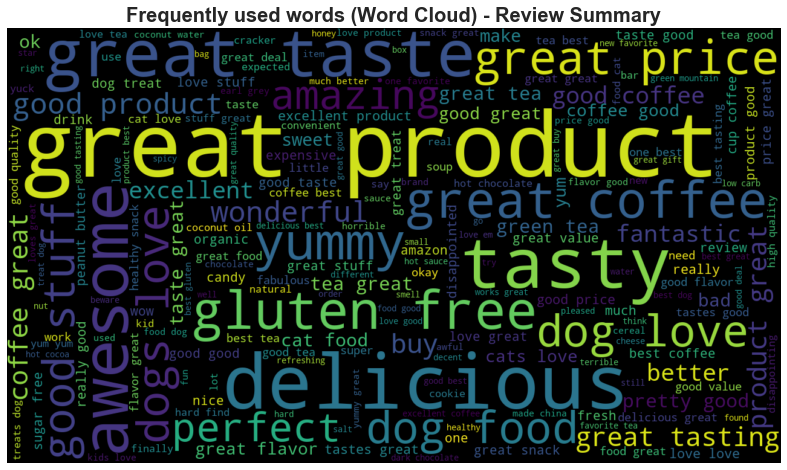

In [137]:
# frequently used words in review summary
list_tokens = df_eda['SummaryTokens'].apply(lambda x: ",".join(word for word in x)).values
corpus = ",".join(string for string in list_tokens)
wordcloud = WordCloud(width=1280, height=720, background_color="black").generate(corpus)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequently used words (Word Cloud) - Review Summary", fontsize=20, fontweight='bold')
plt.show()

In [ ]:
# frequently used words in review text
list_tokens = df_eda['TextTokens'].apply(lambda x: ",".join(word for word in x)).values
corpus = ",".join(string for string in list_tokens)
wordcloud = WordCloud(width=1280, height=720, background_color="black").generate(corpus)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequently used words (Word Cloud) - Review Text", fontsize=20, fontweight='bold')
plt.show()

**Observations:**

* From the above two plots (wordclouds), we can see that majority of the user sentiment is positive.
* From the analysis, we can see that users care more about taste, delicious, and gluten free aspects of the product than price and shipping.
* Most of the products are related to dog food, cat food, coffee, tea, peanut butter, potato chips, cereal, chocolate, soup, etc.

### Bivariate and Multivariate analysis

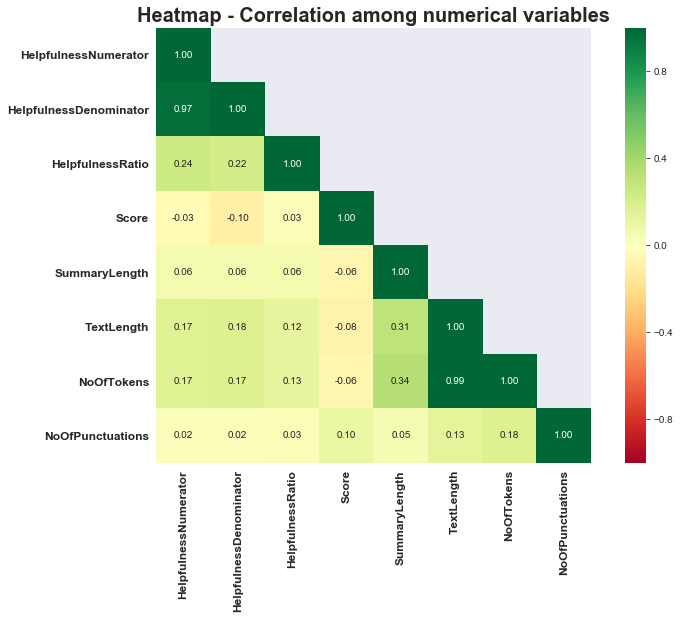

In [139]:
# correlation plot of numerical values
plt.figure(figsize=(12,8))
corr_var = df_eda[['HelpfulnessNumerator','HelpfulnessDenominator','HelpfulnessRatio',
                   'Score',
                   'SummaryLength','TextLength','NoOfTokens','NoOfPunctuations']].corr()
sns.heatmap(corr_var, annot=True, square=True, fmt='.2f', cmap='RdYlGn', vmin=-1, mask=np.triu(corr_var, 1))
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Heatmap - Correlation among numerical variables", fontsize=20, fontweight='bold')
plt.show()

**Observations:**

* There is no or negligeble correlation among metrics.
* There are no interesting observations.

### Helpfulness vs Review summary and text

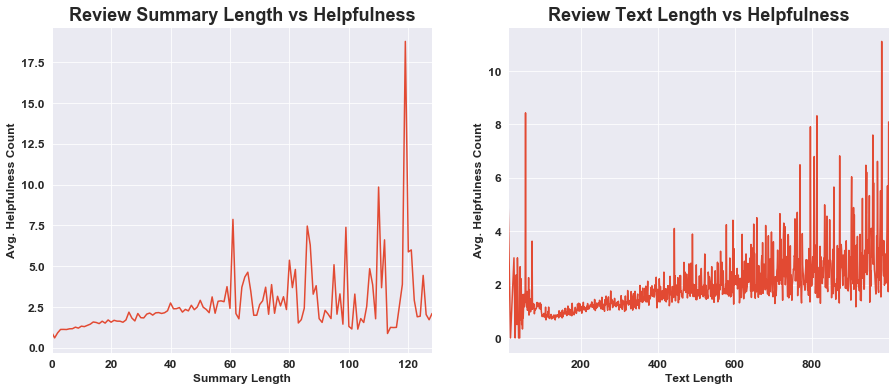

In [140]:
plt.subplots(1,2, figsize=(15,6))

# helpfulness vs review summary length
plt.subplot(1,2,1)
df_eda.groupby('SummaryLength')['HelpfulnessNumerator'].mean().plot()
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Summary Length", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Avg. Helpfulness Count", fontsize=12, fontweight='bold')
plt.title("Review Summary Length vs Helpfulness", fontsize=18, fontweight='bold')

# helpfulness vs review text length
plt.subplot(1,2,2)
df_eda.loc[df_eda['TextLength'] < 1000].groupby('TextLength')['HelpfulnessNumerator'].mean().plot()
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Text Length", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Avg. Helpfulness Count", fontsize=12, fontweight='bold')
plt.title("Review Text Length vs Helpfulness", fontsize=18, fontweight='bold')

plt.show()

**Observations:**

* We can see that as review `Summary` or `Text` length increases, `HelpfulnessNumerator` (no. of users who found the review helpful) also increases (slightly).
* Meaning, users find the review helpful as the details on product increase.

### Score (rating) vs No. of tokens and punctuations

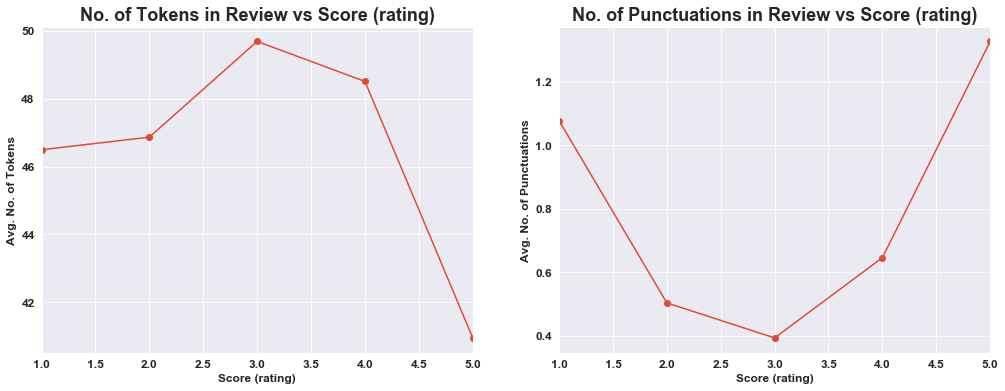

In [141]:
plt.subplots(1,2, figsize=(17,6))

# score vs no. of tokens
plt.subplot(1,2,1)
df_eda.groupby('Score')['NoOfTokens'].mean().plot(marker='o')
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Score (rating)", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Avg. No. of Tokens", fontsize=12, fontweight='bold')
plt.title("No. of Tokens in Review vs Score (rating)", fontsize=18, fontweight='bold')

# helpfulness vs review text length
plt.subplot(1,2,2)
df_eda.groupby('Score')['NoOfPunctuations'].mean().plot(marker='o')
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Score (rating)", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Avg. No. of Punctuations", fontsize=12, fontweight='bold')
plt.title("No. of Punctuations in Review vs Score (rating)", fontsize=18, fontweight='bold')

plt.show()

**Observations:**

* Users who leave a neutral `Score` (product rating), 3 (neutral score), are in general leaving a more detailed review.
* Users who leave an extreme `Score` (product rating), either 1 (very bad) or 5 (very good), are in general leaving less detailed review comparatively.
* Also, users who leave a neutral `Score` (product rating), 3 (neutral score), are in general using few punctuations ("!") in their review.
* Users who leave an extreme `Score` (product rating), either 1 (very bad) or 5 (very good), are in general using more punctuations ("!") in their review.
* Using punctuation ("!") can be ascribed to strong emotion.

### Characteristics of top rated products

In [142]:
# summarizing the metrics product wise
df_product_summary = df_eda.groupby('ProductId')\
                            .agg({'UserId' : 'count',
                                  'HelpfulnessRatio' : 'mean',
                                  'Score' : 'mean',
                                  'SummaryLength' : 'mean',
                                  'SummaryTokens' : 'sum',
                                  'TextLength' : 'mean',
                                  'TextTokens' : 'sum',
                                  'ReviewLength' : 'mean',
                                  'ReviewTokens' : 'sum',
                                  'NoOfTokens' : 'mean',
                                  'NoOfPunctuations' : 'mean'})

In [143]:
# top 100 products
top_100_products = df_product_summary[df_product_summary['UserId'] > 50]\
                        .sort_values('Score', ascending=False)\
                        .head(100)

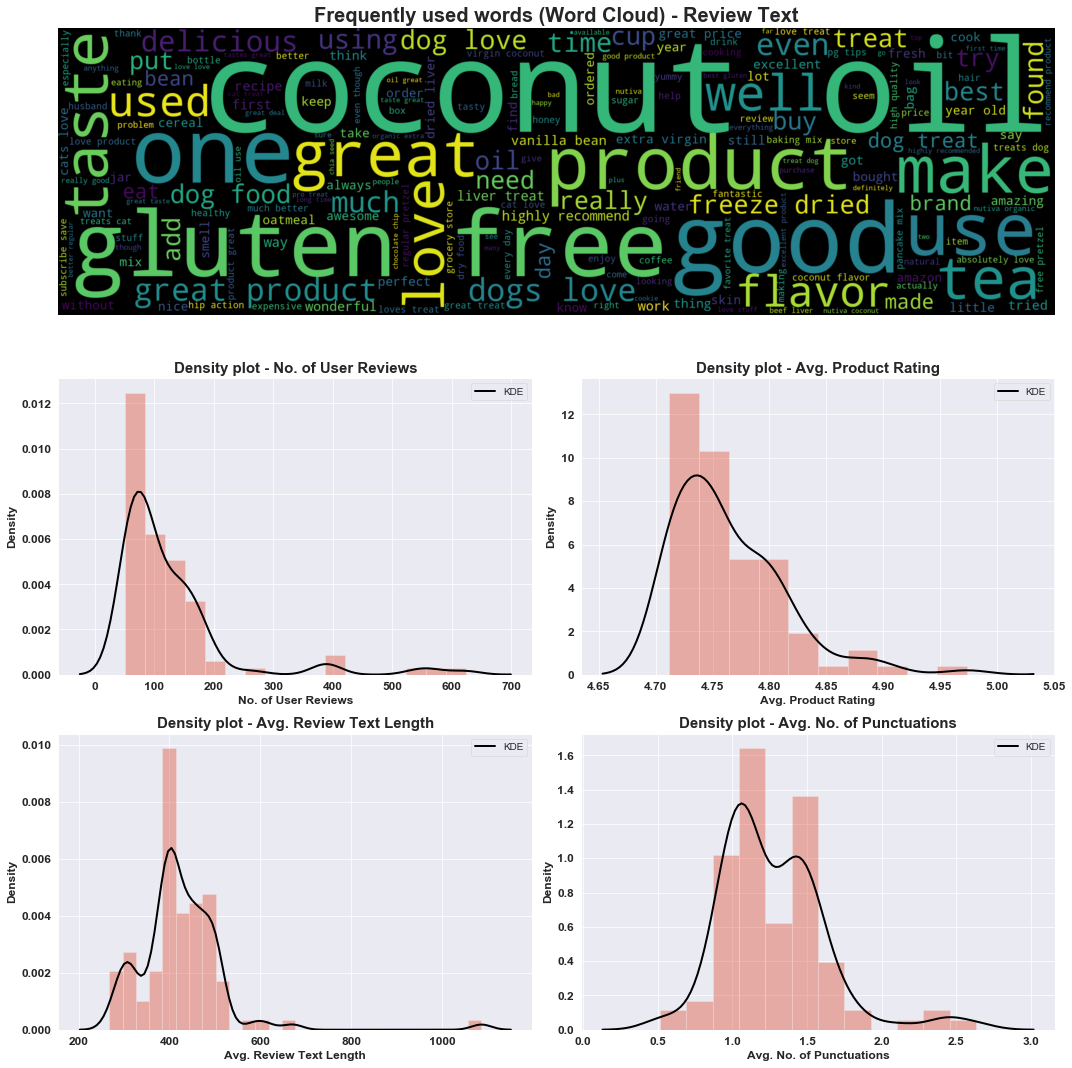

In [144]:
# wordcloud, review length, no. of tokens, no. of punctuations, no. of reviews
plt.subplots(3,2, figsize=(15,15))

# word cloud
plt.subplot(3,2,1)
plt.subplot2grid((3,2), (0, 0), colspan=2)
list_tokens = top_100_products['ReviewTokens'].apply(lambda x: ",".join(word for word in x)).values
corpus = ",".join(string for string in list_tokens)
wordcloud = WordCloud(width=2500, height=720, background_color="black").generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequently used words (Word Cloud) - Review Text", fontsize=20, fontweight='bold')

# distribution of no. of user reviews per product
plt.subplot(3,2,3)
sns.distplot(top_100_products['UserId'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("No. of User Reviews", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - No. of User Reviews", fontsize=15, fontweight='bold')

# distribution of average ratings (scores) for each product
plt.subplot(3,2,4)
sns.distplot(top_100_products['Score'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Avg. Product Rating", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Avg. Product Rating", fontsize=15, fontweight='bold')

# distribution of average review text length for each product
plt.subplot(3,2,5)
sns.distplot(top_100_products['ReviewLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Avg. Review Text Length", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Avg. Review Text Length", fontsize=15, fontweight='bold')

# distribution of average number of punctuations used in review text for each product
plt.subplot(3,2,6)
sns.distplot(top_100_products['NoOfPunctuations'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Avg. No. of Punctuations", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Avg. No. of Punctuations", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

**Observations:**


In [145]:
# bottom 100 products
bottom_100_products = df_product_summary[df_product_summary['UserId'] > 15]\
                            .sort_values('Score')\
                            .head(100)

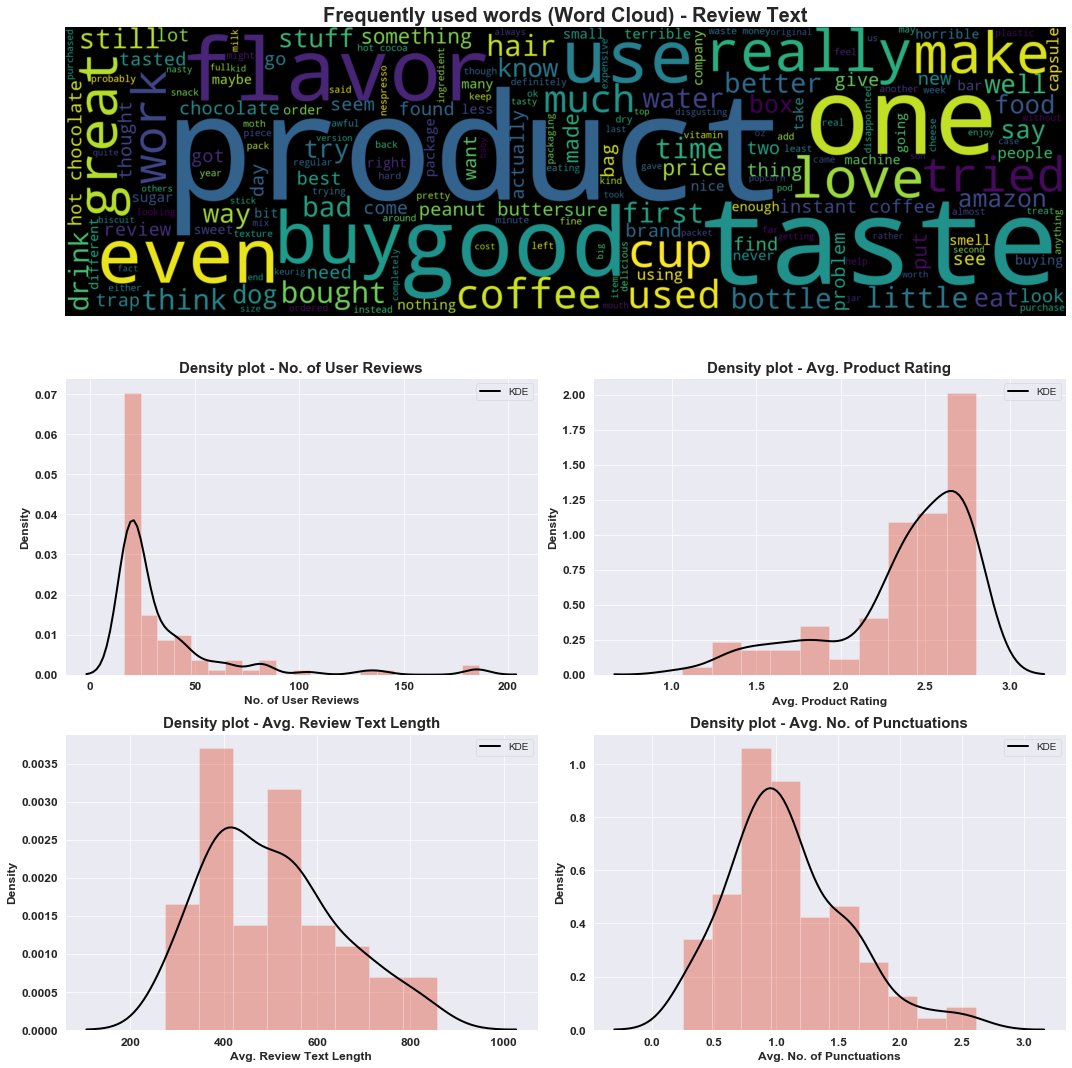

In [146]:
# wordcloud, review length, no. of tokens, no. of punctuations, no. of reviews
plt.subplots(3,2, figsize=(15,15))

# word cloud
plt.subplot(3,2,1)
plt.subplot2grid((3,2), (0, 0), colspan=2)
list_tokens = bottom_100_products['ReviewTokens'].apply(lambda x: ",".join(word for word in x)).values
corpus = ",".join(string for string in list_tokens)
wordcloud = WordCloud(width=2500, height=720, background_color="black").generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequently used words (Word Cloud) - Review Text", fontsize=20, fontweight='bold')

# distribution of no. of user reviews per product
plt.subplot(3,2,3)
sns.distplot(bottom_100_products['UserId'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("No. of User Reviews", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - No. of User Reviews", fontsize=15, fontweight='bold')

# distribution of average ratings (scores) for each product
plt.subplot(3,2,4)
sns.distplot(bottom_100_products['Score'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Avg. Product Rating", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Avg. Product Rating", fontsize=15, fontweight='bold')

# distribution of average review text length for each product
plt.subplot(3,2,5)
sns.distplot(bottom_100_products['ReviewLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Avg. Review Text Length", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Avg. Review Text Length", fontsize=15, fontweight='bold')

# distribution of average number of punctuations used in review text for each product
plt.subplot(3,2,6)
sns.distplot(bottom_100_products['NoOfPunctuations'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Avg. No. of Punctuations", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Avg. No. of Punctuations", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

**Observations:**

### Characteristics (profile) of positive reviews

In [147]:
df_eda.head(1)

ProductId          UserId ProfileName  HelpfulnessNumerator  \
0  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   

   HelpfulnessDenominator  HelpfulnessRatio  Score                Summary  \
0                       1               1.0      5  Good Quality Dog Food   

   SummaryLength               SummaryTokens  \
0             21  [good, quality, dog, food]   

                                                Text  TextLength  \
0  I have bought several of the Vitality canned d...         263   

                                          TextTokens  \
0  [bought, several, vitality, canned, dog, food,...   

                                          ReviewText  ReviewLength  \
0  Good Quality Dog Food I have bought several of...           285   

                                        ReviewTokens  NoOfTokens  \
0  [good, quality, dog, food, bought, several, vi...          27   

   NoOfPunctuations  
0                 0

In [148]:
# subsetting positive reviews
positive_reviews = df_eda[(df_eda['Score'] >= 4) & (df_eda['HelpfulnessDenominator'] > 25)]

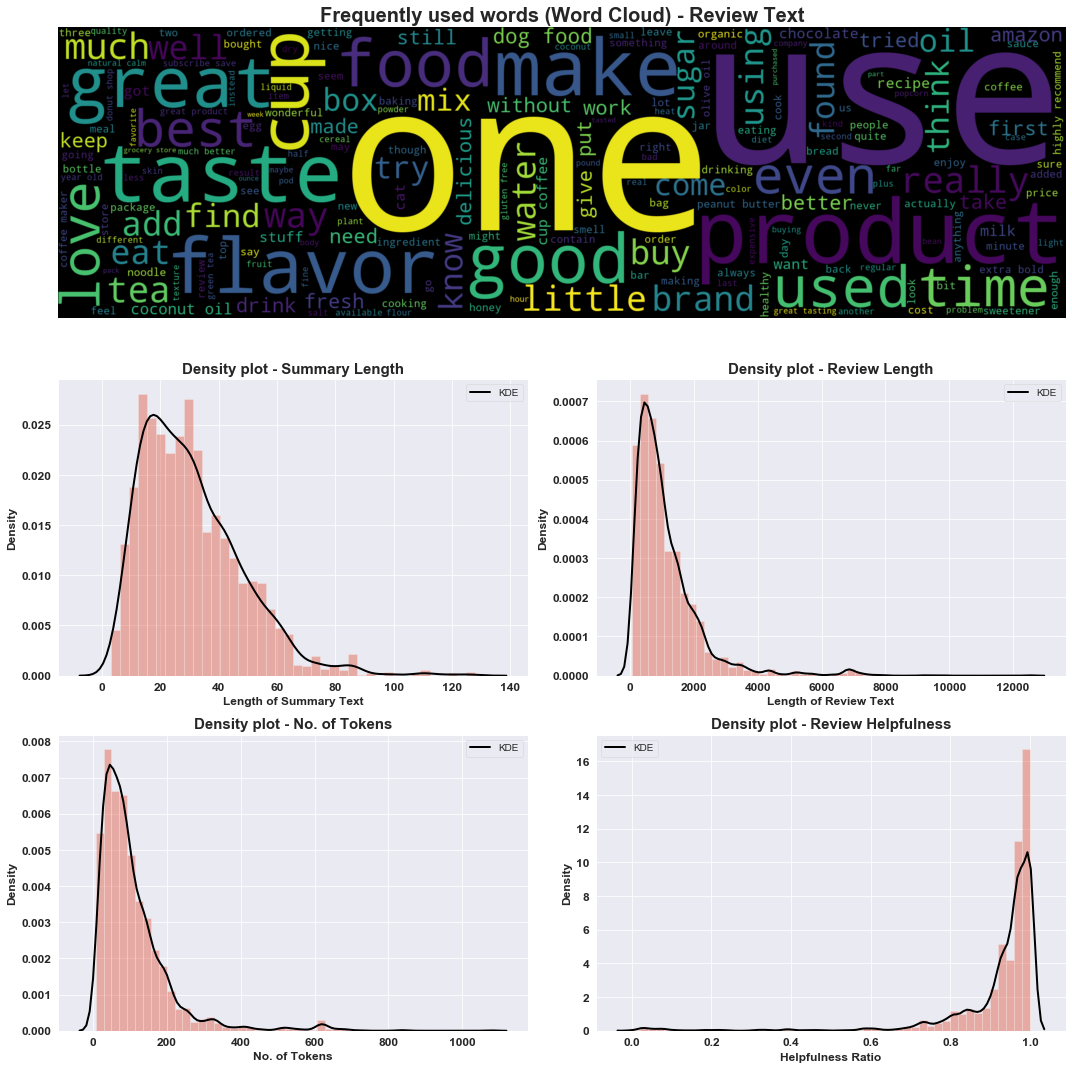

In [149]:
# profile of positive reviews
plt.subplots(3,2, figsize=(15,15))

# word cloud
plt.subplot(3,2,1)
plt.subplot2grid((3,2), (0, 0), colspan=2)
list_tokens = positive_reviews['ReviewTokens'].apply(lambda x: ",".join(word for word in x)).values
corpus = ",".join(string for string in list_tokens)
wordcloud = WordCloud(width=2500, height=720, background_color="black").generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequently used words (Word Cloud) - Review Text", fontsize=20, fontweight='bold')

# distribution of length of summary text
plt.subplot(3,2,3)
sns.distplot(positive_reviews['SummaryLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Length of Summary Text", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Summary Length", fontsize=15, fontweight='bold')

# distribution of length of review text
plt.subplot(3,2,4)
sns.distplot(positive_reviews['TextLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Length of Review Text", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Review Length", fontsize=15, fontweight='bold')

# distribution of no. of tokens in the combined review text
plt.subplot(3,2,5)
sns.distplot(positive_reviews['NoOfTokens'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("No. of Tokens", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - No. of Tokens", fontsize=15, fontweight='bold')

# distribution of helpfulness ratio values
plt.subplot(3,2,6)
sns.distplot(positive_reviews['HelpfulnessRatio'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Helpfulness Ratio", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Review Helpfulness", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

### Characteristics (profile) of negative reviews

In [150]:
# subsetting negative reviews
negative_reviews = df_eda[(df_eda['Score'] < 3) & (df_eda['HelpfulnessDenominator'] > 25)]

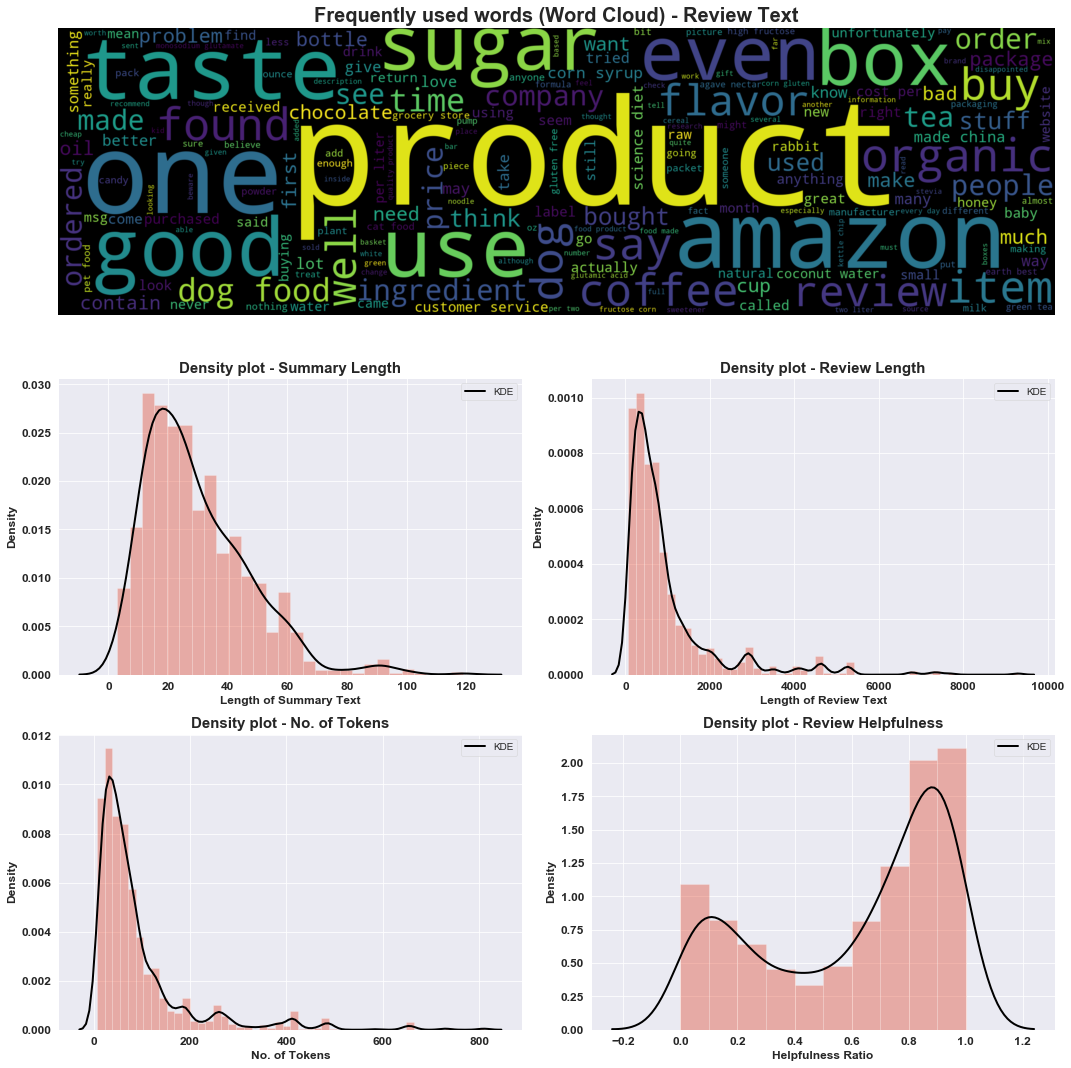

In [151]:
# profile of negative reviews
plt.subplots(3,2, figsize=(15,15))

# word cloud
plt.subplot(3,2,1)
plt.subplot2grid((3,2), (0, 0), colspan=2)
list_tokens = negative_reviews['ReviewTokens'].apply(lambda x: ",".join(word for word in x)).values
corpus = ",".join(string for string in list_tokens)
wordcloud = WordCloud(width=2500, height=720, background_color="black").generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequently used words (Word Cloud) - Review Text", fontsize=20, fontweight='bold')

# distribution of length of summary text
plt.subplot(3,2,3)
sns.distplot(negative_reviews['SummaryLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Length of Summary Text", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Summary Length", fontsize=15, fontweight='bold')

# distribution of length of review text
plt.subplot(3,2,4)
sns.distplot(negative_reviews['TextLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Length of Review Text", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Review Length", fontsize=15, fontweight='bold')

# distribution of no. of tokens in the combined review text
plt.subplot(3,2,5)
sns.distplot(negative_reviews['NoOfTokens'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("No. of Tokens", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - No. of Tokens", fontsize=15, fontweight='bold')

# distribution of helpfulness ratio values
plt.subplot(3,2,6)
sns.distplot(negative_reviews['HelpfulnessRatio'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Helpfulness Ratio", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Review Helpfulness", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

### Positive reviews Vs. Negative reviews

In [152]:
# comparing the stats
positive_reviews_stats = [positive_reviews['SummaryLength'].mean(),
                          positive_reviews['TextLength'].mean(),
                          positive_reviews['NoOfTokens'].mean(),
                          positive_reviews['HelpfulnessRatio'].mean()]

negative_reviews_stats = [negative_reviews['SummaryLength'].mean(),
                          negative_reviews['TextLength'].mean(),
                          negative_reviews['NoOfTokens'].mean(),
                          negative_reviews['HelpfulnessRatio'].mean()]

pd.DataFrame(zip(positive_reviews_stats, negative_reviews_stats),
             index=['Avg. Summary Length', 'Avg. Review Length', 'Avg. No. of Tokens', 'Avg. Review Helpfulness'],
             columns=['Positive Reviews', 'Negative Reviews']).round(2)

Positive Reviews  Negative Reviews
Avg. Summary Length                 30.69             29.55
Avg. Review Length                1126.33            966.63
Avg. No. of Tokens                 107.28             90.48
Avg. Review Helpfulness              0.92              0.61

### Characteristics (profile) of most useful reviews

In [153]:
# subsetting top 1000 most helpful reviews
most_helpful_reviews = df_eda[(df_eda['HelpfulnessDenominator'] > 50)]\
                        .sort_values('HelpfulnessRatio', ascending=False)\
                        .head(1000)

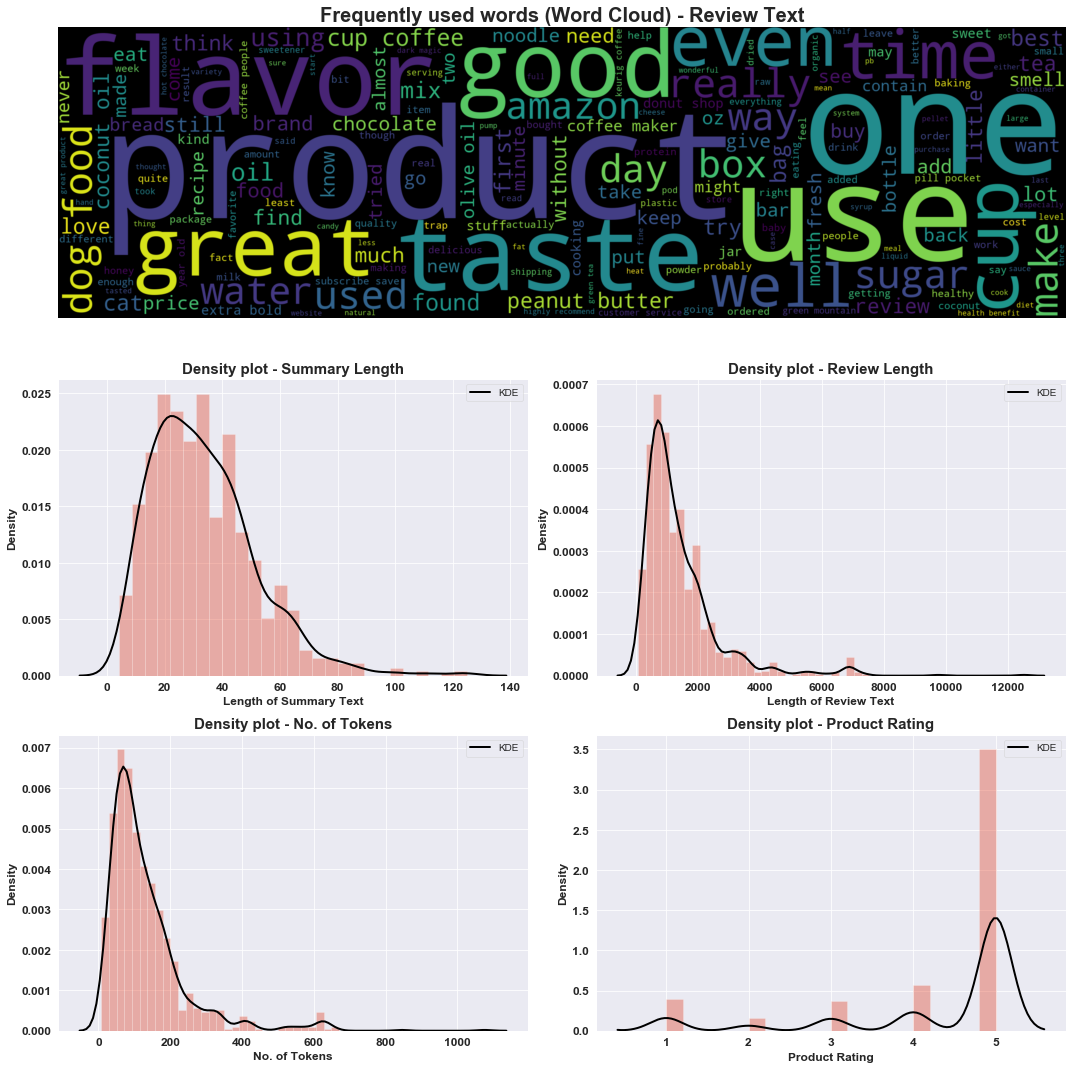

In [154]:
# profile of most helpful reviews
plt.subplots(3,2, figsize=(15,15))

# word cloud
plt.subplot(3,2,1)
plt.subplot2grid((3,2), (0, 0), colspan=2)
list_tokens = most_helpful_reviews['ReviewTokens'].apply(lambda x: ",".join(word for word in x)).values
corpus = ",".join(string for string in list_tokens)
wordcloud = WordCloud(width=2500, height=720, background_color="black").generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequently used words (Word Cloud) - Review Text", fontsize=20, fontweight='bold')

# distribution of length of summary text
plt.subplot(3,2,3)
sns.distplot(most_helpful_reviews['SummaryLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Length of Summary Text", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Summary Length", fontsize=15, fontweight='bold')

# distribution of length of review text
plt.subplot(3,2,4)
sns.distplot(most_helpful_reviews['TextLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Length of Review Text", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Review Length", fontsize=15, fontweight='bold')

# distribution of no. of tokens in the combined review text
plt.subplot(3,2,5)
sns.distplot(most_helpful_reviews['NoOfTokens'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("No. of Tokens", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - No. of Tokens", fontsize=15, fontweight='bold')

# distribution of product rating
plt.subplot(3,2,6)
sns.distplot(most_helpful_reviews['Score'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Product Rating", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Product Rating", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

### Characteristics (profile) of least helpful reviews

In [155]:
# subsetting top 1000 least helpful reviews
least_helpful_reviews = df_eda[(df_eda['HelpfulnessDenominator'] > 50)]\
                        .sort_values('HelpfulnessRatio', ascending=True)\
                        .head(1000)

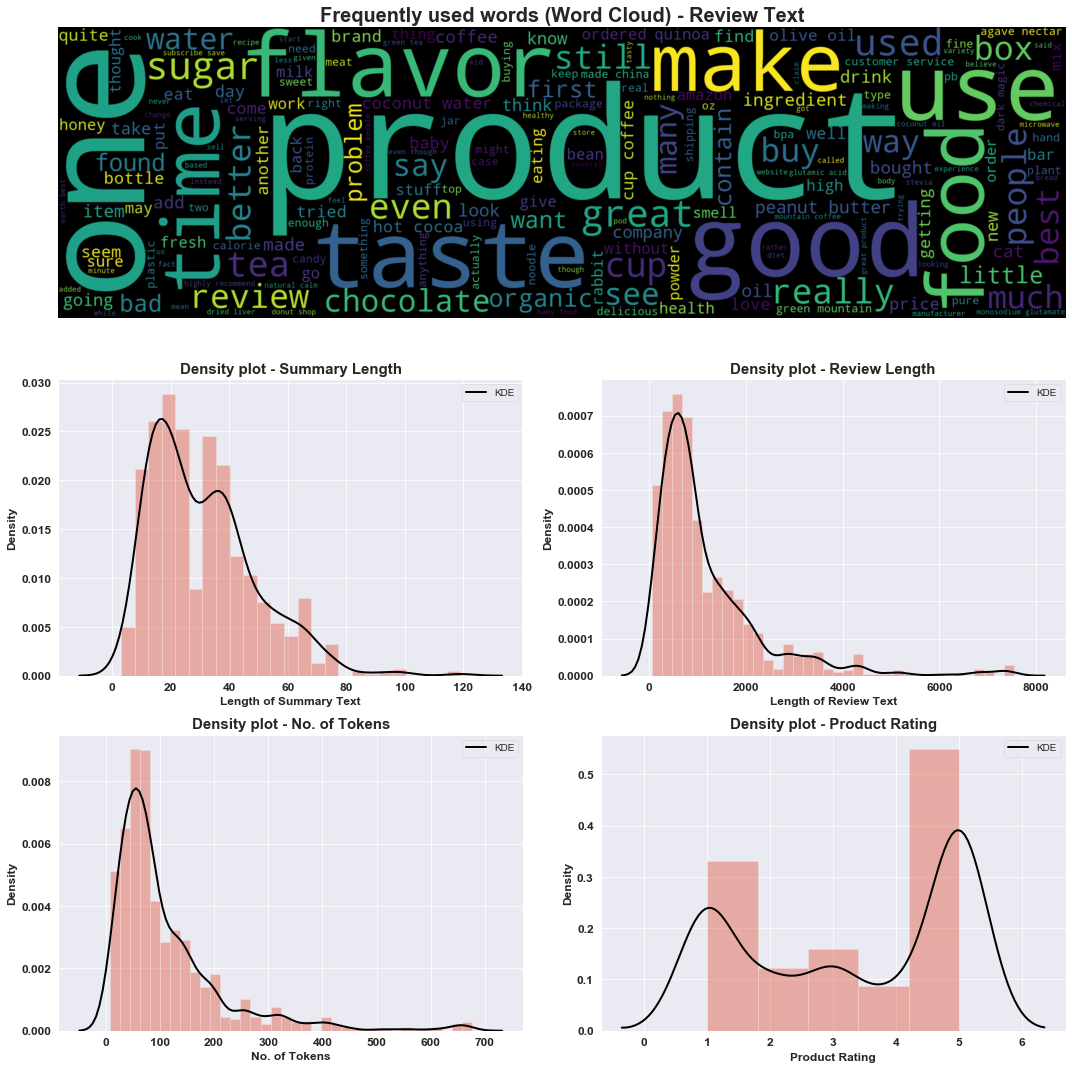

In [156]:
# profile of least helpful reviews
plt.subplots(3,2, figsize=(15,15))

# word cloud
plt.subplot(3,2,1)
plt.subplot2grid((3,2), (0, 0), colspan=2)
list_tokens = least_helpful_reviews['ReviewTokens'].apply(lambda x: ",".join(word for word in x)).values
corpus = ",".join(string for string in list_tokens)
wordcloud = WordCloud(width=2500, height=720, background_color="black").generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequently used words (Word Cloud) - Review Text", fontsize=20, fontweight='bold')

# distribution of length of summary text
plt.subplot(3,2,3)
sns.distplot(least_helpful_reviews['SummaryLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Length of Summary Text", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Summary Length", fontsize=15, fontweight='bold')

# distribution of length of review text
plt.subplot(3,2,4)
sns.distplot(least_helpful_reviews['TextLength'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Length of Review Text", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Review Length", fontsize=15, fontweight='bold')

# distribution of no. of tokens in the combined review text
plt.subplot(3,2,5)
sns.distplot(least_helpful_reviews['NoOfTokens'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("No. of Tokens", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - No. of Tokens", fontsize=15, fontweight='bold')

# distribution of product rating
plt.subplot(3,2,6)
sns.distplot(least_helpful_reviews['Score'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Product Rating", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - Product Rating", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

### Most helpful reviews Vs Least helpful reviews

In [157]:
# comparing the stats
most_helpful_reviews_stats = [most_helpful_reviews['SummaryLength'].mean(),
                              most_helpful_reviews['TextLength'].mean(),
                              most_helpful_reviews['NoOfTokens'].mean(),
                              most_helpful_reviews['Score'].mean(),
                              most_helpful_reviews['NoOfPunctuations'].mean()]

least_helpful_reviews_stats = [least_helpful_reviews['SummaryLength'].mean(),
                               least_helpful_reviews['TextLength'].mean(),
                               least_helpful_reviews['NoOfTokens'].mean(),
                               least_helpful_reviews['Score'].mean(),
                               least_helpful_reviews['NoOfPunctuations'].mean()]
,
pd.DataFrame(zip(most_helpful_reviews_stats, least_helpful_reviews_stats),
             index=['Avg. Summary Length', 'Avg. Review Length', 'Avg. No. of Tokens', 'Avg. Product Rating', 'Avg. No. of Punctuations'],
             columns=['Most Helpful Reviews', 'Least Helpful Reviews']).round(2)

Most Helpful Reviews  Least Helpful Reviews
Avg. Summary Length                      33.28                  30.94
Avg. Review Length                     1391.88                1188.74
Avg. No. of Tokens                      131.44                 111.26
Avg. Product Rating                       4.33                   3.32
Avg. No. of Punctuations                  1.55                   1.46

### Average review user Vs Most helpful review users

In [158]:
# summary stats for each user
df_user_summary = df_eda.groupby('UserId')\
                        .agg({'ProductId' : 'count',
                              'HelpfulnessDenominator' : 'mean',
                              'HelpfulnessRatio' : 'mean',
                              'Score' : 'mean',
                              'SummaryLength' : 'mean',
                              'TextLength' : 'mean',
                              'NoOfTokens' : 'mean',
                              'NoOfPunctuations' : 'mean'})

In [159]:
# middle 50% of users
mask = [False]*64014 + [True]*64014*2 + [False]*64014 + [False]*3

# comparision of metrics
pd.DataFrame(zip(df_user_summary[(df_user_summary['ProductId'] > 3) &
                                 (df_user_summary['HelpfulnessDenominator'] > 10) &
                                 (df_user_summary['HelpfulnessRatio'] > 0.8)].describe().T['mean'].values,
                 df_user_summary.sort_values('HelpfulnessRatio')[mask].describe().T['mean'].values),
             index=df_user_summary.describe().T.index,
             columns=['Top Rated User Review', 'Avg. User Review'])

Top Rated User Review  Avg. User Review
ProductId                            7.402672          2.863100
HelpfulnessDenominator              25.715109          2.978328
HelpfulnessRatio                     0.925644          0.335051
Score                                4.189472          3.999651
SummaryLength                       28.175089         22.674415
TextLength                         843.770072        394.166766
NoOfTokens                          80.937407         39.532389
NoOfPunctuations                     1.423179          1.103811

# Recommendation engines

### Scoring metric

In [160]:
# model score
df['ModelScore'] = df['SentimentScore'] * (df['Score'] / 5)

### Preparing data

In [161]:
# function to filter rows less than min frequencies
def filter_min_frequencies(df_filter, feature, min_freq):
    feature_frequencies = df_filter[feature].value_counts()
    df_filter = df_filter[df_filter[feature].isin(feature_frequencies[feature_frequencies > min_freq].index)]
    return df_filter

In [162]:
# subsetting data for modelling
df_model = df[['ProductId','UserId','ModelScore']]

In [163]:
# setting threshold for min frequencies
min_freq = 10

# product frequencies
product_frequencies = df_model['ProductId'].value_counts()
# user frequencies
user_frequencies = df_model['UserId'].value_counts()

# appending product and user frequencies to dataframe
df_model['product_frequency'] = df_model['ProductId'].apply(lambda x: product_frequencies[x])
df_model['user_frequency'] = df_model['UserId'].apply(lambda x: user_frequencies[x])

# filtering products and users less than min frequency threshold
while ((df_model['ProductId'].value_counts(ascending=True)[0] < min_freq) or (df_model['UserId'].value_counts(ascending=True)[0] < min_freq)):
    df_model = filter_min_frequencies(df_model, "ProductId", min_freq)
    df_model = filter_min_frequencies(df_model, "UserId", min_freq)

# encoding ProductId and UserId
df_model['UID'] = pd.factorize(df_model['UserId'])[0]
df_model['PID'] = pd.factorize(df_model['ProductId'])[0]

# dictionary - PID to ProductId
pid_to_productid = df_model[['ProductId','PID']].drop_duplicates().set_index('PID')

# splitting into train and test sets
X = df_model[['UID','PID']]
y = df_model['ModelScore']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=911)
train = np.array(X_train.join(y_train))
test = np.array(X_test.join(y_test))

# model matrix
model_matrix = np.array(X.join(y))

# model matrix dimensions
model_products = df_model['ProductId'].nunique()
model_users = df_model['UserId'].nunique()

# constructing user-product matrix
user_product_matrix = np.zeros([model_users, model_products])

for row in model_matrix:
    uid, pid, score = row
    uid, pid = int(uid), int(pid)
    if user_product_matrix[uid][pid] < score:
        user_product_matrix[uid][pid] = score

C:\Users\rahul\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\rahul\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [164]:
Pdts_total = df_model['PID'].unique().shape[0]
Users_total = df_model['UID'].unique().shape[0]

### Modelling

In [165]:
# function to calculate RMSE
def evaluate_rmse(matrix_pred):
    # in sample (train) RMSE
    sigma_train, sigma_pred = [], []
    for row in train:
        u, p, s = row
        u, p = int(u), int(p)
        sigma_train.append(s)
        sigma_pred.append(matrix_pred[u][p])
    rmse_in_sample = np.sqrt(mean_squared_error(sigma_train, sigma_pred))
    
    # out sample (test) RMSE
    sigma_test, sigma_pred = [], []
    for row in test:
        u, p, s = row
        u, p = int(u), int(p)
        sigma_test.append(s)
        sigma_pred.append(matrix_pred[u][p])
    rmse_out_sample = np.sqrt(mean_squared_error(sigma_test, sigma_pred))
    
    return rmse_in_sample, rmse_out_sample

In [166]:
# function to plot confusion matrix
def plot_confusion_matrix(matrix_pred):
    y_test, y_pred = [], []
    
    for row in test:
        u, p, s = row
        u, p = int(u), int(p)
        if s >= 0.75:
            y_test.append(1)
        else:
            y_test.append(0)
        if matrix_pred[u][p] >= 0.75:
            y_pred.append(1)
        else:
            y_pred.append(0)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # normalizing
    cm = cm / cm.sum(axis=1).reshape(-1,1)
    # plotting
    cm = pd.DataFrame(cm,
                      columns=['Not Recommended','Recommended'],
                      index=['Not Recommended','Recommended'])

    cm = cm.round(2)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, cmap="RdYlGn", annot=True, cbar=False, square=True)
    plt.xlabel("Predicted values", fontsize=15, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.ylabel("Actual values", fontsize=15, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.title("Confusion Matrix", fontsize=20, fontweight='bold')
    plt.show()

In [167]:
# function to recommend products
def recommend_products(results, uid, top_n=10):
    # checking if the user has bought at least 10 items in the past
    if uid in df_model['UID'].values:
        top_n_products = np.argpartition(results[uid], -top_n)[-top_n:]
        user_id = df_model.loc[(df_model['UID'] == 10), 'UserId'].head(1).values[0]
        products = [pid_to_productid.iloc[pid, 0] for pid in top_n_products]
        print(f"For the user {user_id} top {top_n} recommended products are:\n{products}")
        
    else:
        print("This user has not bought anything, please use other methods.")

### SVD

In [168]:
# average user scores for each product
avg_product_scores = np.mean(user_product_matrix,axis=0).reshape(1,-1)

# subtracting avg. product scores from the the user product matrix
demeaned_matrix = user_product_matrix - avg_product_scores

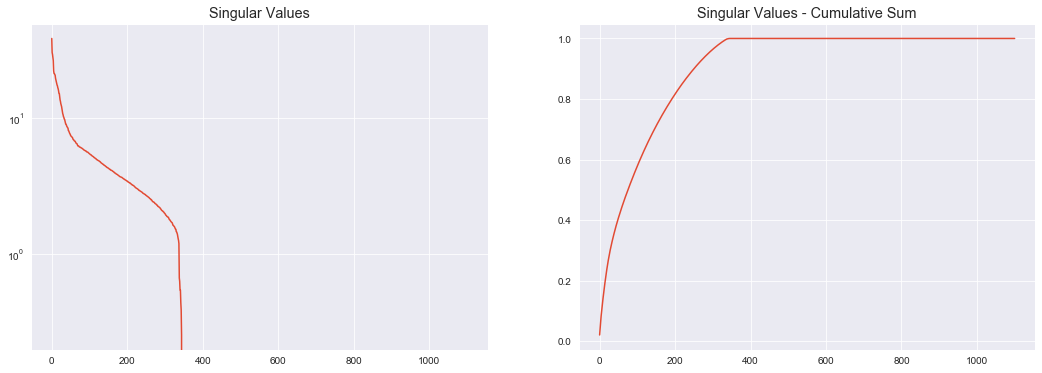

In [169]:
# choosing the no. of factors
# SVD
U, S, VT = svds(demeaned_matrix, k=1101)

# sigma values
s = np.diag(S)
s = np.diag(s)[::-1]

# visualizing the information carried
plt.subplots(1,2, figsize=(18,6))
plt.subplot(1,2,1)
plt.semilogy(s)
plt.title("Singular Values")

plt.subplot(1,2,2)
plt.plot(np.cumsum(s) / np.sum(s))
plt.title("Singular Values - Cumulative Sum")
plt.show()

**Observations:**

* We can see that the initial 350 sigma values are capturing most of the information. Let's choose k as 350 factors.

In [182]:
# SVD with 350 factors
U, S, VT = svds(demeaned_matrix, k=350)

# fetching sigma value
S = np.diag(S)

# constructing the predicted matrix using sigma values from SVD
matrix_pred = np.dot(np.dot(U, S), VT) + avg_product_scores

# scaling the values to [0-1] range
mms = MinMaxScaler(feature_range=(0,1))
results_svd = mms.fit_transform(matrix_pred).round(2)

In [183]:
# RMSE
rmse_svd = evaluate_rmse(results_svd)
print(f"RMSE train: {train_rmse}\nRMSE test: {test_rmse}")

RMSE train: 0.1195741570247125
RMSE test: 0.12172339446519655


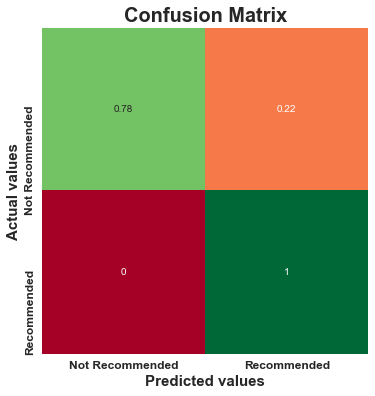

In [185]:
# plotting confusion matrix
plot_confusion_matrix(results_svd)

### Distance based - cosine similarity

In [173]:
user_similarity = pairwise_distances(user_product_matrix, metric='cosine')
item_similarity = pairwise_distances(user_product_matrix.T, metric='cosine')

mm_scaler = MinMaxScaler(feature_range=(0,1))
result_cosine = mm_scaler.fit_transform(np.dot(user_similarity,user_product_matrix).dot(item_similarity))

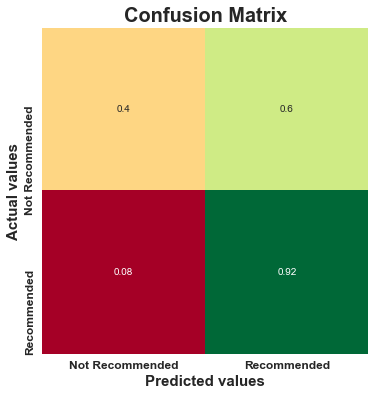

In [174]:
rmse_cosine = evaluate_rmse(result_cosine)
plot_confusion_matrix(result_cosine)

### Matrix Factorization

In [175]:
def Matrix_factorization(data=model_matrix, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=False):
    
    #Initial latent matrices for user and product
    P = np.random.rand(Users_total, factors) / 3
    Q = np.random.rand(Pdts_total, factors) / 3
    
    #Initialize history of losses
    y = []
    
    #Iteration number
    iteration = 0
    last_loss = 0
    
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            
            #Fetch user ID, Product ID and ModelScore
            u, p, s = data[i]
            
            #Error calculation
            error = s - np.dot(P[int(u)], Q[int(p)])
            
            #Scaling loss to avoid large values
            loss += error ** 2 / 50
            
            #Gradient descent updation
            pp = P[int(u)]
            qq = Q[int(p)]
            P[int(u)] += LRate * error * qq
            Q[int(p)] += LRate * error * pp
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        
        #Updating the learning rate for convergence
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5
        
        #Stopping criteria for gradient descent
        if abs(delta_loss) < abs(GD_end):
            print('the difference in loss is {}, Gradient Descent is stopped'.format(delta_loss))
            break
        last_loss = loss

    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)

iter = 1, loss = 84.7857438096513, delta_loss = -84.7857438096513, LR = 0.02
iter = 2, loss = 45.49400015616401, delta_loss = 39.29174365348728, LR = 0.01
iter = 3, loss = 38.860930412955604, delta_loss = 6.633069743208409, LR = 0.0105
iter = 4, loss = 34.157947392818016, delta_loss = 4.702983020137587, LR = 0.011025000000000002
iter = 5, loss = 30.48530843197898, delta_loss = 3.6726389608390377, LR = 0.011576250000000003
iter = 6, loss = 27.474245674882106, delta_loss = 3.011062757096873, LR = 0.012155062500000004
iter = 7, loss = 24.937113008622966, delta_loss = 2.53713266625914, LR = 0.012762815625000005
iter = 8, loss = 22.76418703483532, delta_loss = 2.1729259737876454, LR = 0.013400956406250006
iter = 9, loss = 20.88453220178451, delta_loss = 1.879654833050811, LR = 0.014071004226562506
iter = 10, loss = 19.248583523140862, delta_loss = 1.635948678643647, LR = 0.014774554437890632
iter = 11, loss = 17.819505848978455, delta_loss = 1.4290776741624072, LR = 0.015513282159785164
ite

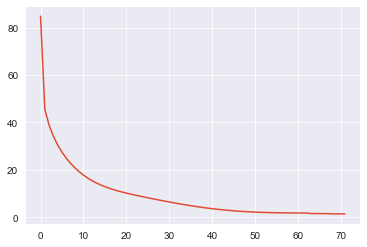

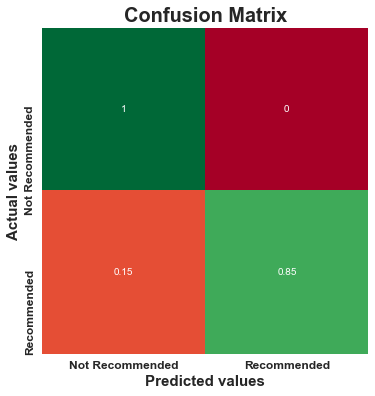

In [176]:
result_mf = Matrix_factorization(factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
rmse_mf = evaluate_rmse(result_mf)
plot_confusion_matrix(result_mf)

### Probabilistic Matrix Factorization

In [177]:
#Similar to Matrix Factorization
def PMF(data=model_matrix, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, regU = 0.01 ,regI = 0.01 ,plot=False):
    
    #Initial latent matrices
    P = np.random.rand(Users_total, factors) / 3
    Q = np.random.rand(Pdts_total, factors) / 3
    
    #History of losses
    y = []
    
    #Iteration count
    iteration = 0
    last_loss = 100
    
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            u, p, s = data[i]
            error = s - np.dot(P[int(u)], Q[int(p)])
            loss += error ** 2/50
            pp = P[int(u)]
            qq = Q[int(p)]
            P[int(u)] += LRate *  (error * qq - regU*pp)
            Q[int(p)] += LRate * (error * pp - regI * qq)
        loss += regU*(P*P).sum() +regI*(Q*Q).sum()
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))

        #Update learning loss for convergence
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5

        if abs(delta_loss) < abs(GD_end):
            print('the difference in loss is {}, so the Gradient Descent is stopped'.format(delta_loss))
            break
        last_loss = loss
    
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)

iter = 1, loss = 132.86597476612897, delta_loss = -32.86597476612897, LR = 0.02
iter = 2, loss = 91.35527570093117, delta_loss = 41.5106990651978, LR = 0.01
iter = 3, loss = 84.10372011416248, delta_loss = 7.2515555867686885, LR = 0.0105
iter = 4, loss = 78.94151556592632, delta_loss = 5.162204548236161, LR = 0.011025000000000002
iter = 5, loss = 74.90190322097268, delta_loss = 4.039612344953639, LR = 0.011576250000000003
iter = 6, loss = 71.58590079962715, delta_loss = 3.31600242134553, LR = 0.012155062500000004
iter = 7, loss = 68.78930259236097, delta_loss = 2.796598207266186, LR = 0.012762815625000005
iter = 8, loss = 66.39205605316951, delta_loss = 2.397246539191457, LR = 0.013400956406250006
iter = 9, loss = 64.31599203221133, delta_loss = 2.076064020958185, LR = 0.014071004226562506
iter = 10, loss = 62.50595536122228, delta_loss = 1.8100366709890494, LR = 0.014774554437890632
iter = 11, loss = 60.92047867848527, delta_loss = 1.58547668273701, LR = 0.015513282159785164
iter = 12

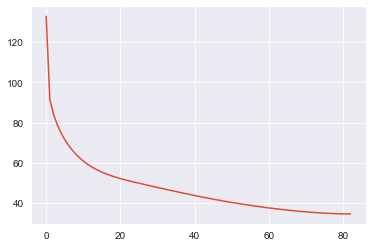

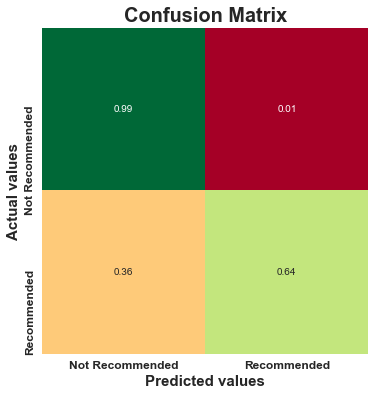

In [178]:
result_pmf = PMF(factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
rmse_pmf = evaluate_rmse(result_pmf)
plot_confusion_matrix(result_pmf)

## Comparing different models

In [179]:
#Store train and test RMSE values for each model in a dictionary
metrics_dict = {'Dist Based': rmse_cosine, 'SVD': rmse_svd, 'MF': rmse_mf, 'PMF': rmse_pmf}
metrics_df = pd.DataFrame(metrics_dict)

#Dataframe with indices as train and test
list_index = ['Train RMSE','Test RMSE']
metrics_df.index = list_index
metrics_df.round(3)

Dist Based    SVD     MF    PMF
Train RMSE       0.389  0.120  0.033  0.056
Test RMSE        0.387  0.122  0.032  0.055

We see that Matrix Factorization model gives the best values in terms of RMSE.

## Product Recommendation

In [180]:
#We take the example of user number 10. We first look at what products they've reviewed
df_user10 = df_model[df_model['UID'] == 10]

df_user10

ProductId          UserId  ModelScore  product_frequency  \
434     B000G6RYNE  A15USNEAJUXOSH    0.469333                217   
435     B000G6RYNE  A15USNEAJUXOSH    0.653274                217   
26009   B0058AMY74  A15USNEAJUXOSH    0.469333                217   
26010   B0058AMY74  A15USNEAJUXOSH    0.653274                217   
56525   B0012XBD7I  A15USNEAJUXOSH    0.469333                218   
56526   B0012XBD7I  A15USNEAJUXOSH    0.653274                218   
67747   B000G6MBUA  A15USNEAJUXOSH    0.469333                217   
67748   B000G6MBUA  A15USNEAJUXOSH    0.653274                217   
78538   B00472I5A4  A15USNEAJUXOSH    0.469333                218   
78539   B00472I5A4  A15USNEAJUXOSH    0.653274                218   
112894  B000LKXBL4  A15USNEAJUXOSH    0.469333                217   
112895  B000LKXBL4  A15USNEAJUXOSH    0.653274                217   
228647  B0058AMY10  A15USNEAJUXOSH    0.469333                218   
228648  B0058AMY10  A15USNEAJUXOSH    0.653274                218   
331784  B0058AMYTC  A15USNEAJUXOSH    0.469333                217   
331785  B0058AMYTC  A15USNEAJUXOSH    0.653274                217   
403223  B0058AMY5G  A15USNEAJUXOSH    0.469333                217   
403224  B0058AMY5G  A15USNEAJUXOSH    0.653274                217   
466443  B000G6O2QG  A15USNEAJUXOSH    0.469333                218   
466444  B000G6O2QG  A15USNEAJUXOSH    0.653274                218   
497796  B000LKVD5U  A15USNEAJUXOSH    0.469333                217   
497797  B000LKVD5U  A15USNEAJUXOSH    0.653274                217   
539450  B006WYSFZK  A15USNEAJUXOSH    0.469333                218   
539451  B006WYSFZK  A15USNEAJUXOSH    0.653274                218   
549191  B004728MI4  A15USNEAJUXOSH    0.469333                218   
549192  B004728MI4  A15USNEAJUXOSH    0.653274                218   
550278  B001SAXPEO  A15USNEAJUXOSH    0.469333                218   
550279  B001SAXPEO  A15USNEAJUXOSH    0.653274                218   

        user_frequency  UID   PID  
434                 28   10     0  
435                 28   10     0  
26009               28   10    52  
26010               28   10    52  
56525               28   10   106  
56526               28   10   106  
67747               28   10   127  
67748               28   10   127  
78538               28   10   151  
78539               28   10   151  
112894              28   10   216  
112895              28   10   216  
228647              28   10   455  
228648              28   10   455  
331784              28   10   644  
331785              28   10   644  
403223              28   10   799  
403224              28   10   799  
466443              28   10   918  
466444              28   10   918  
497796              28   10   967  
497797              28   10   967  
539450              28   10  1051  
539451              28   10  1051  
549191              28   10  1067  
549192              28   10  1067  
550278              28   10  1072  
550279              28   10  1072

Next, we fetch data about these products from Amazon to get a better idea of the recommendations. These are the unique products the user has reviewed:

- Kettle Brand Potato Chips, Unsalted, 5 Ounce Bags
- Kettle Brand Potato Chips, Sea Salt and Vinegar Kettle Chips
- Kettle Brand Potato Chips, Backyard Barbeque
- Kettle Brand Potato Chips, Sea Salt and Vinegar
- Kettle Brand Jalapeno Chips
- Kettle Brand Potato Chips, Sea Salt
- Kettle Brand Potato Chips, Backyard Barbeque
- Kettle Brand Potato Chips, Jalapeno Kettle Chips
- Kettle Brand Potato Chips, Sea Salt, Single-Serve 1 Ounce Bags
- Kettle Brand Potato Chips, Honey Dijon Bags
- Kettle Brand Potato Chips, Sea Salt and Vinegar, 8.5 Ounce Bags
- Kettle Brand Potato Chips, Sea Salt, Single-Serve 1.5 Ounce Bags 
- Kettle Brand Jalapeno Chip, 9-ounces 
- Kettle Brand Chips, Sweet Onion, 2-ounces

In [181]:
#Running the recommendation for products for this user
recommend_products(result_mf, 10, top_n = 5)

For the user A15USNEAJUXOSH top 5 recommended products are:
['B001CWSKFC', 'B001EO5Q64', 'B000GW0UGG', 'B000EVG8HY', 'B000FBOAOQ']


Inputting these in Amazon, we see that these are the top 5 recommended products for User 10

- Jules Destrooper Almond Thins, Belgian Almond Butter Cookies
- Happy Tot Organic Stage 4 Super Foods Apples Sweet Potatoes Carrots & Cinnamon
- Glutino Lemon Wafers, 7.1-Ounce Boxes
- Jules Destrooper Butter Waffles, Belgian Vanilla Flavored Butter Cookies
- Glutino Chocolate Vanilla Creme Dream Cookies